## Imports

In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib inline to creating seperate window for matplotlib figures it will draw it in cell output instead

## Read Dataset

In [2]:
words = open("/kaggle/input/eureka-labs/names.txt","r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

## char to id

In [4]:
chars     = sorted(list(set(''.join(words))))
stoi      = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos      = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Dataset

In [5]:
def build_dataset(words):
    block_size = 3 # context length : how many characters do we take to predict next one
    X, Y       = [],[]

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] #crop and apppend

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte   = build_dataset(words[n2])

## Initialize weights

In [6]:
n_hidden   = 64 # the number of neurons in the hidden layer of the MLP
vocab_size = 27
n_embd     = 10 # the dimensionality of the character embedding vectors
block_size = 3

g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5) #kamming dist 
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 #for making initial weights near to zero to mask un uinform distribution

W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

bngain = torch.randn((1,n_hidden)) * 0.1 + 1.0   #Batch normalization trainable parameter
bnbias = torch.randn((1,n_hidden)) * 0.1  #Batch normalization trainable parameter


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

## Forward pass

In [7]:
batch_size = 32
n          = batch_size

# minibatch
ix         = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb     = Xtr[ix], Ytr[ix]

In [8]:
#forward pass "chunkated" into smaller steps that are possible to backward one at a time
emb     = C[Xb] #embed the characters into the vectors
embcat  = emb.view(emb.shape[0], -1) # concate the vectors

#Linear layer 1
hprebn  = embcat @ W1 + b1 #hidden layer pre activation

#------------------------------- BatchNorm layer -------------------------------
bnmeani   = 1/n*hprebn.sum(0, keepdim=True)
bndiff    = hprebn - bnmeani
bndiff2   = bndiff**2
bnvar     = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) Check notes for more info
bnvar_inv = (bnvar + 1e-5)**-0.5 #?? (bnvar + 0.00001)/2
bnraw     = bndiff * bnvar_inv
hpreact   = bngain * bnraw + bnbias
#------------------------------------------------------------------------------
#Non linearity
h              = torch.tanh(hpreact) #hidden layer

#Linear layer 2
logits         = h @ W2 + b2 # output layer
#-----------------------------loss function------------------------------------------------
logit_maxes    = logits.max(1, keepdim=True).values
norm_logits    = logits - logit_maxes                    # subtract max for numerical stability cause high values lead to instability as we are exponentiating them
counts         = norm_logits.exp()                       #taking natural(e^x) exponent of all values from tensor
counts_sum     = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1                          # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs          = counts * counts_sum_inv
logprobs       = probs.log()                             #natural logaritham of all elements from the tensor.
loss           = -logprobs[range(n), Yb].mean()
#-----------------------------------------------------------------------------

#Backward pass
for p in parameters:
    p.grad = None
    
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3207, grad_fn=<NegBackward0>)

In [9]:
# logprobs[(0,1),(0,1)]

In [10]:
#utility function we are going to use later for comparing manual gradients with PyTorch gradients
def cmp(s, dt, t):
    ex      = torch.all(dt == t.grad).item() # Extractly equal : checking if all values are equal by precision also if yes it retruns boolean value as .item()
    app     = torch.allclose(dt, t.grad)     # Approximatly equal by precision level is ignored
    maxdiff = (dt - t.grad).abs().max().item() # highest absolute diffrence
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [11]:
#norm_logits    = logits - logit_maxes
# c11 c12 c13 = a11 a12 a13   b1
# c21 c22 c23 = a21 a22 a23 - b2
# c31 c32 c33 = a31 a32 a33   b3

#so e.g C32 = a32 - b3

#norm_logits    = logits - logit_maxes - this operation is for numerical stability only so it dose not impact the 
# loss at all so it's derivative is zero

## Exercise 1 :-> Backward pass manually

In [12]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs               = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n                          #d(loss)/d(logprobs) = -1/n
dprobs                  = (1.0 / probs) * dlogprobs         #d/dx log(x)         = 1/x   # Boosting the gradients where probs is low if it is 1 then we just pass grads in back layer
dcounts_sum_inv         = (counts * dprobs).sum(1, keepdim=True) # count : (32,27) * (32,1) using broadcasting for sum operation
dcounts                 = counts_sum_inv * dprobs
dcounts_sum             = (-counts_sum**-2) * dcounts_sum_inv #d(x**-1)/dx = -1/x**2 
dcounts                += torch.ones_like(counts) * dcounts_sum
dnorm_logits            = counts * dcounts                    #d(e^x)/dx = x     
dlogits                 = dnorm_logits.clone()
dlogit_maxes            = (-dnorm_logits).sum(1, keepdim=True) #drivaties flow as it is through nodes for -ve and +ve operations.
dlogits                += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh                      = dlogits @ W2.T # for more clarification see the video : 51:00 hrs
dW2                     = h.T @ dlogits  #--
db2                     = dlogits.sum(0) #--

dhpreact                = (1.0 - h**2) * dh #d(tanh(x))/dx = 1 - tanh(x) ** 2

dbngain                 = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw                  = bngain * dhpreact
dbnbias                 = dhpreact.sum(0, keepdim=True)
dbndiff                 = bnvar_inv * dbnraw
dbnvar_inv              = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar                  = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv # d(x^y)/dw = y * (x ^ (y-1))
dbndiff2                = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff                += (2*bndiff) * dbndiff2
dhprebn                 = dbndiff.clone()
dbnmeani                = (-dbndiff).sum(0)
dhprebn                += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat                 = dhprebn @ W1.T        # In multiplication it is transpose of other element and global derivative
dW1                     = embcat.T @ dhprebn    # In multiplication it is transpose of other element and global derivative
db1                     = dhprebn.sum(0)        # in add operation derivates flows as it we just have to consider right using brodcasting
demb                    = dembcat.view(emb.shape)  # just undoing the view operation from forward pass

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    
cmp('logprobs',       dlogprobs,        logprobs)
cmp('probs',          dprobs,           probs)
cmp('counts_sum_inv', dcounts_sum_inv,  counts_sum_inv)
cmp('counts_sum',     dcounts_sum,      counts_sum)
cmp('counts',         dcounts,          counts)
cmp('logit_maxes',    dlogit_maxes,     logit_maxes)
cmp('logits',         dlogits,          logits)

cmp('h',              dh,               h)
cmp('W2',             dW2,              W2)
cmp('b2',             db2,              b2)

cmp('hpreact',        dhpreact,         hpreact)

cmp('bngain',         dbngain,          bngain)
cmp('bnraw',          dbnraw,           bnraw)
cmp('bnbias',         dbnbias,          bnbias)
cmp('bnvar_inv',      dbnvar_inv,       bnvar_inv)
cmp('bnvar',          dbnvar,           bnvar)
cmp('bndiff2',        dbndiff2,         bndiff2)
cmp('bndiff',         dbndiff,          bndiff)
cmp('bnmeani',        dbnmeani,         bnmeani)
cmp('hprebn',         dhprebn,          hprebn)

cmp('embcat',         dembcat,          embcat)
cmp('W1',             dW1,              W1)
cmp('b1',             db1,              b1)

cmp('emb',            demb,             emb)
cmp('C',              dC,               C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain          | exact: False | approximate: True  | maxdiff: 2.0954757928848267e-09
bnraw           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298

## Exercise 2 :-> 

In [13]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

In [14]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

In [15]:
# now
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.320688009262085 diff: 0.0


In [16]:
# backward pass - for derivative check notes from capacities
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


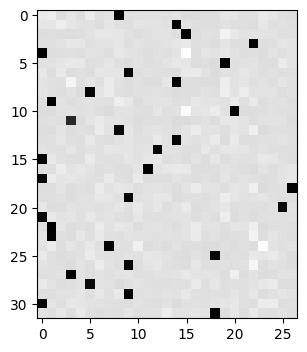

In [17]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

## Exercise - 3

In [18]:
#Task : Calculate the backward pass of batch normalization in one go

# Backward pass
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

In [19]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# Simplified derivation of backward pass
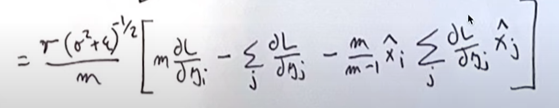

In [20]:
# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


# Exercise - 4

In [21]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

In [22]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [23]:
# same optimization as last time
max_steps  = 20000
batch_size = 32
n          = batch_size # convenience
lossi      = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix     = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb    = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean    = hprebn.mean(0, keepdim=True)
    bnvar     = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw     = (hprebn - bnmean) * bnvar_inv
    hpreact   = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h      = torch.tanh(hpreact) # hidden layer
    
    logits = h @ W2 + b2 # output layer
    loss   = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits  = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    
    # 2nd layer backprop
    dh  = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    
    # tanh
    dhpreact = (1.0 - h**2) * dh
    
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1     = embcat.T @ dhprebn
    db1     = dhprebn.sum(0)
    
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
            
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

      0/  20000: 3.8039
   1000/  20000: 2.2407
   2000/  20000: 2.3149
   3000/  20000: 2.2199
   4000/  20000: 2.1851
   5000/  20000: 2.3186
   6000/  20000: 2.1376
   7000/  20000: 2.4850
   8000/  20000: 2.0049
   9000/  20000: 2.1781
  10000/  20000: 2.2092
  11000/  20000: 1.8729
  12000/  20000: 2.2541
  13000/  20000: 2.2383
  14000/  20000: 2.6715
  15000/  20000: 2.1163
  16000/  20000: 2.4775
  17000/  20000: 2.2564
  18000/  20000: 1.9879
  19000/  20000: 2.4472


In [24]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [25]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
      }[split]
     
    emb     = C[x] # (N, block_size, n_embd)
    embcat  = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h       = torch.tanh(hpreact) # (N, n_hidden)
    logits  = h @ W2 + b2 # (N, vocab_size)
    loss    = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2121996879577637
val 2.2301130294799805


In [26]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out     = []
    context = [0] * block_size # initialize with all ...
    
    while True:
        
        # ------------
        # forward pass:
        # Embedding
        emb     = C[torch.tensor([context])] # (1,block_size,d)      
        embcat  = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h       = torch.tanh(hpreact) # (N, n_hidden)
        logits  = h @ W2 + b2 # (N, vocab_size)
        
        # ------------
        # Sample
        probs   = F.softmax(logits, dim=1)
        ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mri.
almyanziee.
mad.
ryah.
rethretted.
lei.
azeer.
melin.
shi.
jen.
eden.
estana.
analeigh.
karin.
sadbergihi.
jest.
jair.
jelina.
tero.
kunzey.
